# 스타벅스 매장 데이터 수집하기

In [2]:
# 필요 라이브러리 호출
import pandas as pd
import requests
import numpy as np

#url을 통해 스타벅스 매장의 데이터를 수집하는 함수
def get_starbucks_store(url):
    
    # 데이터를 수집할 때 필요한 데이터
    data = {
    'p_sido_cd':'', 
    'p_gugun_cd':'',  
    'in_biz_cd':'',
    'set_date':'',
    'iend':'10000'  #최대 인덱스 수..?
    }
    
    # 데이터 요청(post방식)
    response = requests.post(url, data=data)
    stores = pd.read_json(response.text)['list']
    
    # 필요한 컬럼판 리스트에 담아주기
    list_store = []
    for store in stores:
        list_store.append([store['s_code'],
                        store['s_name'],
                        store['sido_name'],
                        store['gugun_name'],
                        store['doro_address'],
                        store['open_dt'],
                        store['lat'],
                        store['lot']])
    df_store = pd.DataFrame(list_store)
    
    # 컬럼 명 변경
    cols=['매장코드', '매장이름', '시/도', '구/군', '도로명주소', '오픈날짜', '위도', '경도']
    df_store.columns = cols
    
    # 위도 경도 실수형으로 타입변경
    df_store['위도'] = df_store['위도'].astype(float)
    df_store['경도'] = df_store['경도'].astype(float)
    
    # 이름에 있는 정보로 매장 타입 추출 및 생성
    dt_r_dtr = [
        df_store['매장이름'].str.endswith('DT'),
        df_store['매장이름'].str.endswith('R') & ~df_store['매장이름'].str.endswith('DTR'),
        df_store['매장이름'].str.endswith('DTR')]
    choicelist = ['DriveThrough', 'Reserve', 'DriveThrough&Reserve']
    df_store['매장타입'] = np.select(dt_r_dtr, choicelist, default='General')
    
    return df_store

In [3]:
# get_starbucks_store(url)함수를 통해 전체 스타벅스 매장 정보 확인
df_store = get_starbucks_store('https://www.starbucks.co.kr/store/getStore.do')
df_store

,매장코드,매장이름,시/도,구/군,도로명주소,오픈날짜,위도,경도,매장타입
0,1694,송파마천사거리DT,서울,송파구,서울특별시 송파구 거마로 78 (마천동),20200825,37.499829,127.147672,DriveThrough
1,1711,그랜드조선 부산,부산,해운대구,부산광역시 해운대구 해운대해변로 292 (중동),20201007,35.160034,129.163051,General
2,1713,서울웨이브아트센터,서울,서초구,서울특별시 서초구 잠원로 145-35 (잠원동),20200929,37.518807,127.007040,General
3,1720,명동남산,서울,중구,서울특별시 중구 퇴계로 132 (남산동3가),20201015,37.560809,126.986397,General
4,1807,센텀몰1F,부산,해운대구,부산광역시 해운대구 센텀4로 15 (우동),20210513,35.169810,129.127783,General
...,...,...,...,...,...,...,...,...,...
1773,1610,수원경수인계DT,경기,수원시 팔달구,경기도 수원시 팔달구 경수대로 499 (인계동),20200131,37.270568,127.027566,DriveThrough
1774,1611,호계지식산업센터,경기,안양시 동안구,경기도 안양시 동안구 엘에스로 122 (호계동) 118~123호,20200218,37.372351,126.948665,General
1775,1614,안동이마트,경북,안동시,경상북도 안동시 옥동1길 2 (옥동),20200207,36.558505,128.699308,General
1776,1616,월계역,서울,노원구,"서울특별시 노원구 초안산로2라길26 월계동(104,105,106호)",20200218,37.629500,127.057400,General


In [4]:
# 결측치 확인! (구/군)에서 결측치가 있음을 알 수 있다
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1778 entries, 0 to 1777
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   매장코드    1778 non-null   object 
 1   매장이름    1778 non-null   object 
 2   시/도     1778 non-null   object 
 3   구/군     1766 non-null   object 
 4   도로명주소   1778 non-null   object 
 5   오픈날짜    1778 non-null   object 
 6   위도      1778 non-null   float64
 7   경도      1778 non-null   float64
 8   매장타입    1778 non-null   object 
dtypes: float64(2), object(7)
memory usage: 125.1+ KB


In [5]:
# 구/군 컬럼의 결측치가 어느 데이터에서 생겼는지 확인!
# 시/도 가 세종특별시 인곳에서 결측치가 생김!
df_store[df_store['구/군'].isna()]

,매장코드,매장이름,시/도,구/군,도로명주소,오픈날짜,위도,경도,매장타입
6,1814,세종충남대학교병원,세종,None,세종특별자치시 보듬7로 20 (도담동) 헬스케어센터 1층,20210609,36.519360,127.258280,General
105,1750,세종소담,세종,None,"세종특별자치시 소담3로 8 (소담동) 1동 12호,13호,14호,15호,15a호,16호",20210115,36.485755,127.300509,General
178,2041,세종한솔,세종,None,세종특별자치시 노을3로 101 (한솔동),20220929,36.479955,127.253348,General
267,1768,세종아름,세종,None,"세종특별자치시 아름서1길 13-9 (아름동) 103,104,105,202,203호",20210226,36.511880,127.242770,General
864,717,세종청사,세종,None,세종특별자치시 도움8로 81 (어진동),20140108,36.504565,127.270769,General
1015,894,세종이마트,세종,None,세종특별자치시 금송로 687(가람동 406) 이마트 세종점,20150205,36.471219,127.250997,General
1033,858,세종첫마을,세종,None,세종특별자치시 한누리대로 169 행복타워 1층,20141125,36.480383,127.261795,General
1094,917,세종종촌,세종,None,세종특별자치시 도움3로 105-10 (종촌동) 성운프라자,20150424,36.504112,127.249381,General
1263,1092,세종어진R,세종,None,세종특별자치시 한누리대로 499 (어진동),20160714,36.508188,127.261188,Reserve
1313,1257,세종새롬,세종,None,세종특별자치시 새롬중앙로 64 (새롬동),20170817,36.486896,127.250718,General


In [11]:
# 결측치를 세종시로 대체
df_store = df_store.fillna('세종시')

In [12]:
# 결측치가 잘 대체되었는지 확인
print(df_store.info())
df_store[df_store['시/도']=='세종']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1778 entries, 0 to 1777
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   매장코드    1778 non-null   object 
 1   매장이름    1778 non-null   object 
 2   시/도     1778 non-null   object 
 3   구/군     1778 non-null   object 
 4   도로명주소   1778 non-null   object 
 5   오픈날짜    1778 non-null   object 
 6   위도      1778 non-null   float64
 7   경도      1778 non-null   float64
 8   매장타입    1778 non-null   object 
dtypes: float64(2), object(7)
memory usage: 138.9+ KB
None


,매장코드,매장이름,시/도,구/군,도로명주소,오픈날짜,위도,경도,매장타입
6,1814,세종충남대학교병원,세종,세종시,세종특별자치시 보듬7로 20 (도담동) 헬스케어센터 1층,20210609,36.519360,127.258280,General
105,1750,세종소담,세종,세종시,"세종특별자치시 소담3로 8 (소담동) 1동 12호,13호,14호,15호,15a호,16호",20210115,36.485755,127.300509,General
178,2041,세종한솔,세종,세종시,세종특별자치시 노을3로 101 (한솔동),20220929,36.479955,127.253348,General
267,1768,세종아름,세종,세종시,"세종특별자치시 아름서1길 13-9 (아름동) 103,104,105,202,203호",20210226,36.511880,127.242770,General
864,717,세종청사,세종,세종시,세종특별자치시 도움8로 81 (어진동),20140108,36.504565,127.270769,General
1015,894,세종이마트,세종,세종시,세종특별자치시 금송로 687(가람동 406) 이마트 세종점,20150205,36.471219,127.250997,General
1033,858,세종첫마을,세종,세종시,세종특별자치시 한누리대로 169 행복타워 1층,20141125,36.480383,127.261795,General
1094,917,세종종촌,세종,세종시,세종특별자치시 도움3로 105-10 (종촌동) 성운프라자,20150424,36.504112,127.249381,General
1263,1092,세종어진R,세종,세종시,세종특별자치시 한누리대로 499 (어진동),20160714,36.508188,127.261188,Reserve
1313,1257,세종새롬,세종,세종시,세종특별자치시 새롬중앙로 64 (새롬동),20170817,36.486896,127.250718,General


In [13]:
# 중복값 확인 및 제거(중복값 없음)

display(df_store.shape)
df_store = df_store.drop_duplicates()
display(df_store.shape)

(1778, 9)

(1778, 9)

In [14]:
# 오브젝트 타입변수 기술통계 확인
df_store.describe(include = "O")

,매장코드,매장이름,시/도,구/군,도로명주소,오픈날짜,매장타입
count,1778,1778,1778,1778,1778,1778,1778
unique,1778,1778,18,153,1767,1214,4
top,1694,송파마천사거리DT,서울,중구,경기도 하남시 미사대로 750 (신장동),20201210,General
freq,1,1,599,90,3,7,1313


In [15]:
# 도로명 주소가 같아도 매장은 다르다!
df_store[df_store['도로명주소'] == '경기도 하남시 미사대로 750 (신장동)']

,매장코드,매장이름,시/도,구/군,도로명주소,오픈날짜,위도,경도,매장타입
1293,1108,스타필드하남2FR,경기,하남시,경기도 하남시 미사대로 750 (신장동),20160905,37.545300,127.224200,Reserve
1294,1109,신세계하남2F,경기,하남시,경기도 하남시 미사대로 750 (신장동),20160905,37.545734,127.223439,General
1295,1110,스타필드하남1F(티바나),경기,하남시,경기도 하남시 미사대로 750 (신장동),20160905,37.544500,127.223700,General


In [16]:
df_store

,매장코드,매장이름,시/도,구/군,도로명주소,오픈날짜,위도,경도,매장타입
0,1694,송파마천사거리DT,서울,송파구,서울특별시 송파구 거마로 78 (마천동),20200825,37.499829,127.147672,DriveThrough
1,1711,그랜드조선 부산,부산,해운대구,부산광역시 해운대구 해운대해변로 292 (중동),20201007,35.160034,129.163051,General
2,1713,서울웨이브아트센터,서울,서초구,서울특별시 서초구 잠원로 145-35 (잠원동),20200929,37.518807,127.007040,General
3,1720,명동남산,서울,중구,서울특별시 중구 퇴계로 132 (남산동3가),20201015,37.560809,126.986397,General
4,1807,센텀몰1F,부산,해운대구,부산광역시 해운대구 센텀4로 15 (우동),20210513,35.169810,129.127783,General
...,...,...,...,...,...,...,...,...,...
1773,1610,수원경수인계DT,경기,수원시 팔달구,경기도 수원시 팔달구 경수대로 499 (인계동),20200131,37.270568,127.027566,DriveThrough
1774,1611,호계지식산업센터,경기,안양시 동안구,경기도 안양시 동안구 엘에스로 122 (호계동) 118~123호,20200218,37.372351,126.948665,General
1775,1614,안동이마트,경북,안동시,경상북도 안동시 옥동1길 2 (옥동),20200207,36.558505,128.699308,General
1776,1616,월계역,서울,노원구,"서울특별시 노원구 초안산로2라길26 월계동(104,105,106호)",20200218,37.629500,127.057400,General


In [19]:
df_store.to_csv('scraping_starbucs_store_team_shasha4.csv',index=False, encoding="utf-8-sig")

## 내집에서 가장 가까운 매장은????

In [ ]:
!pip install geopy
!pip install Haversine
from geopy.geocoders import Nominatim
from haversine import haversine

In [10]:
# 가장 가까운 매장의 데이터를 찾아주는 함수
def find_closest_store(lat, lot):
    diff_square = (lat - df_store['위도']) ** 2 + (lot - df_store['경도']) ** 2
    return df_store[diff_square == min(diff_square)]

In [11]:
# 현재 위치를 위도, 경도 값으로 변환!
# !pip install geopy
# from geopy.geocoders import Nominatim

geo_local = Nominatim(user_agent='South Korea')

# 주소를 입력하면 위도 경도 값이 나오는 함수
def geocoding(address):
    try:
        geo = geo_local.geocode(address)
        x_y = [geo.latitude, geo.longitude]
        return x_y

    except:
        print("다시 입력해주세요.")
        return [0,0]

In [ ]:
# 가장 가까운 매장 찾기
# me = input("지역을 입력해 주세요(도로명 주소가 더 잘 작동합니다) :")
# my_location = geocoding(me)

# my_lot = my_location[0]
# my_lat = my_location[1]

# print(my_location)
# find_closest_store(my_lot,my_lat)

In [ ]:
#가장 가까운 매장과 거리 계산
# !pip install Haversine
# from haversine import haversine

# me = (my_lot, my_lat)
# my_lot = my_location[0]
# my_lat = my_location[1]

# closest_starbucks = find_closest_store(my_lot, my_lat)
# closest_starbucks_lot_lat = (closest_starbucks.iloc[0, 6], closest_starbucks.iloc[0, 7])

# # 거리 계산
# distance_1 = haversine((my_lot, my_lat), closest_starbucks_lot_lat, unit = 'km')
# distance = (str(round(distance_1, 2)) +'km 거리에 스타벅스 매장이 있습니다.')
# print(distance)


In [12]:
# 가장 가까운 매장과 거리 계산(위의 코드 한번에 작동시키기)
# !pip install Haversine
# from haversine import haversine

me = input("지역을 입력해 주세요(도로명 주소가 더 잘 작동합니다) :")
my_location = geocoding(me)

my_lot = my_location[0]
my_lat = my_location[1]

closest_starbucks = find_closest_store(my_lot, my_lat)
closest_starbucks_lot_lat = (closest_starbucks.iloc[0, 6], closest_starbucks.iloc[0, 7])

# 거리 계산
distance_1 = haversine((my_lot, my_lat), closest_starbucks_lot_lat, unit = 'km')
distance = (str(round(distance_1, 2)) +'km 거리에 ' + closest_starbucks.iloc[0, 1] + ' 매장이 있습니다.')
print(distance)
closest_starbucks

지역을 입력해 주세요(도로명 주소가 더 잘 작동합니다) :신송로6번길
0.53km 거리에 송도캠퍼스타운역 매장이 있습니다.


,매장코드,매장이름,시/도,구/군,도로명주소,오픈날짜,위도,경도,매장타입
1205,1088,송도캠퍼스타운역,인천,연수구,인천광역시 연수구 송도과학로27번길 55 (송도동) 롯데캠퍼스타운,20160628,37.387428,126.663648,General


# 스타벅스 이야기


In [13]:
# 하루에 오픈 날짜가 장 많은 날짜?
mode_open_date = df_store['오픈날짜'].mode().loc[0]
print(mode_open_date)
df_store[df_store['오픈날짜'] == mode_open_date]

20201210


,매장코드,매장이름,시/도,구/군,도로명주소,오픈날짜,위도,경도,매장타입
93,1738,춘의역DT,경기,부천시,경기도 부천시 길주로 386 (춘의동),20201210,37.503080,126.785460,DriveThrough
262,1731,해운대좌동,부산,해운대구,부산광역시 해운대구 좌동순환로 178 (좌동),20201210,35.177594,129.175590,General
273,1735,전주인후DT,전북,전주시 덕진구,전라북도 전주시 덕진구 아중로 135 (인후동1가),20201210,35.825831,127.164394,DriveThrough
274,1744,의정부장암DT,경기,의정부시,경기도 의정부시 동일로 114 (장암동),20201210,37.699250,127.054650,DriveThrough
375,1740,용산해링턴스퀘어,서울,용산구,서울특별시 용산구 서빙고로 17 (한강로3가),20201210,37.525856,126.967644,General
376,1741,마산월남동DT,경남,창원시,경상남도 창원시 마산합포구 3·15대로 70 (월남동2가),20201210,35.186017,128.561302,DriveThrough
377,1742,거제옥포DT,경남,거제시,경상남도 거제시 거제대로 3718 (옥포동),20201210,34.889180,128.691540,DriveThrough


## 가장 오래된 매장

In [14]:
# 스타벅스 매장 데이터에서 가장 오래된 매장과 실제 가장 오래된 매장이 일치하는지 확인!
first_store = df_store[df_store['오픈날짜']
                       == min(df_store['오픈날짜'])]
first_store

,매장코드,매장이름,시/도,구/군,도로명주소,오픈날짜,위도,경도,매장타입
752,149,이대R,서울,서대문구,서울특별시 서대문구 이화여대길 34 (대현동),19990727,37.558483,126.945964,Reserve


## 2019년 리저브 매장으로 리뉴얼(이대R점 인 이유)

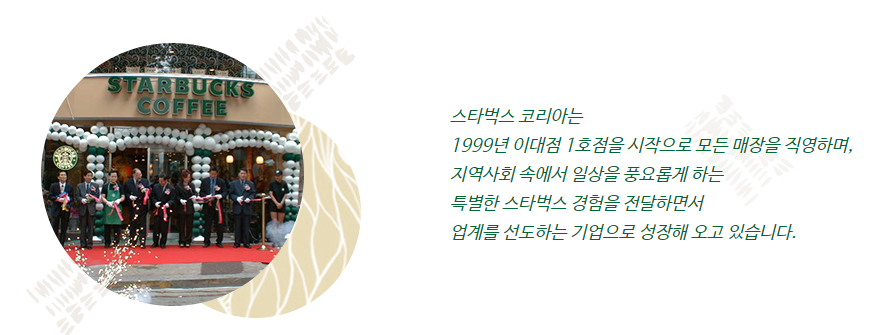

출처 : https://www.starbucks.co.kr/footer/company/starbucks_information.do

## DT 매장 1호점

In [15]:
# 스타벅스 매장 데이터에서 가장 오래된 드라이브스루매장과 실제 가장 오래된 드라이브스루 매장이 일치하는지 확인!
df_dt_store = df_store[df_store['매장타입']
                        == 'DriveThrough']
first_dt_store = df_dt_store[df_dt_store['오픈날짜']
                       == min(df_dt_store['오픈날짜'])]
first_dt_store

,매장코드,매장이름,시/도,구/군,도로명주소,오픈날짜,위도,경도,매장타입
455,550,경주보문로DT,경북,경주시,"경상북도 경주시 보문로 510-6, 외 1번지(신평동 719-220) (천군동)",20120910,35.838831,129.285953,DriveThrough


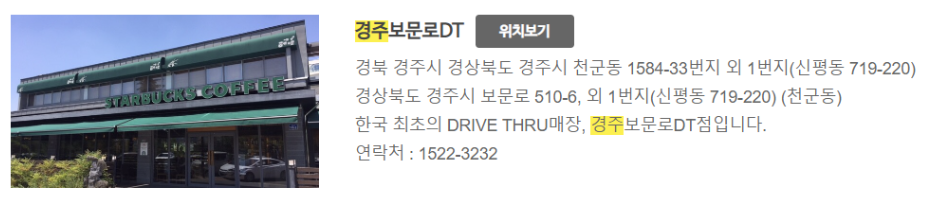
출처 : https://www.starbucks.co.kr/search/search.do?search=1%25ED%2598%25B8%25EC%25A0%2590

## 유일한 DTR 매장

In [16]:
#유일한 DTR매장 확인
dtr_store = df_store[df_store['매장타입']
                        == 'DriveThrough&Reserve']
dtr_store

,매장코드,매장이름,시/도,구/군,도로명주소,오픈날짜,위도,경도,매장타입
180,1676,더양평DTR,경기,양평군,경기도 양평군 양평읍 양근로 76,20200724,37.497398,127.48173,DriveThrough&Reserve


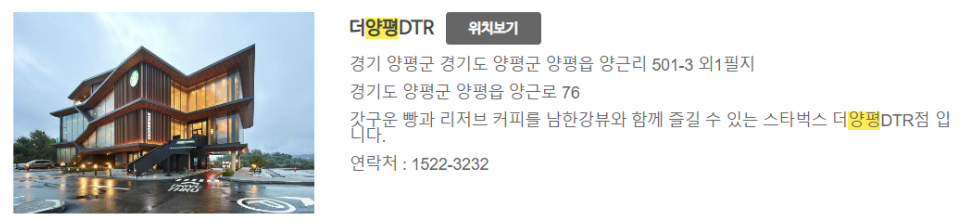
출처 : https://www.starbucks.co.kr/search/search.do?search=%25EC%2596%2591%25ED%258F%2589

## 시도 별 매장 개수

시/도
서울     599
경기     421
부산     132
대구      79
경남      70
인천      70
광주      61
대전      61
경북      53
충남      42
울산      34
전북      31
전남      29
충북      27
제주      26
강원      22
세종      12
강원도      9
dtype: int64


<BarContainer object of 18 artists>

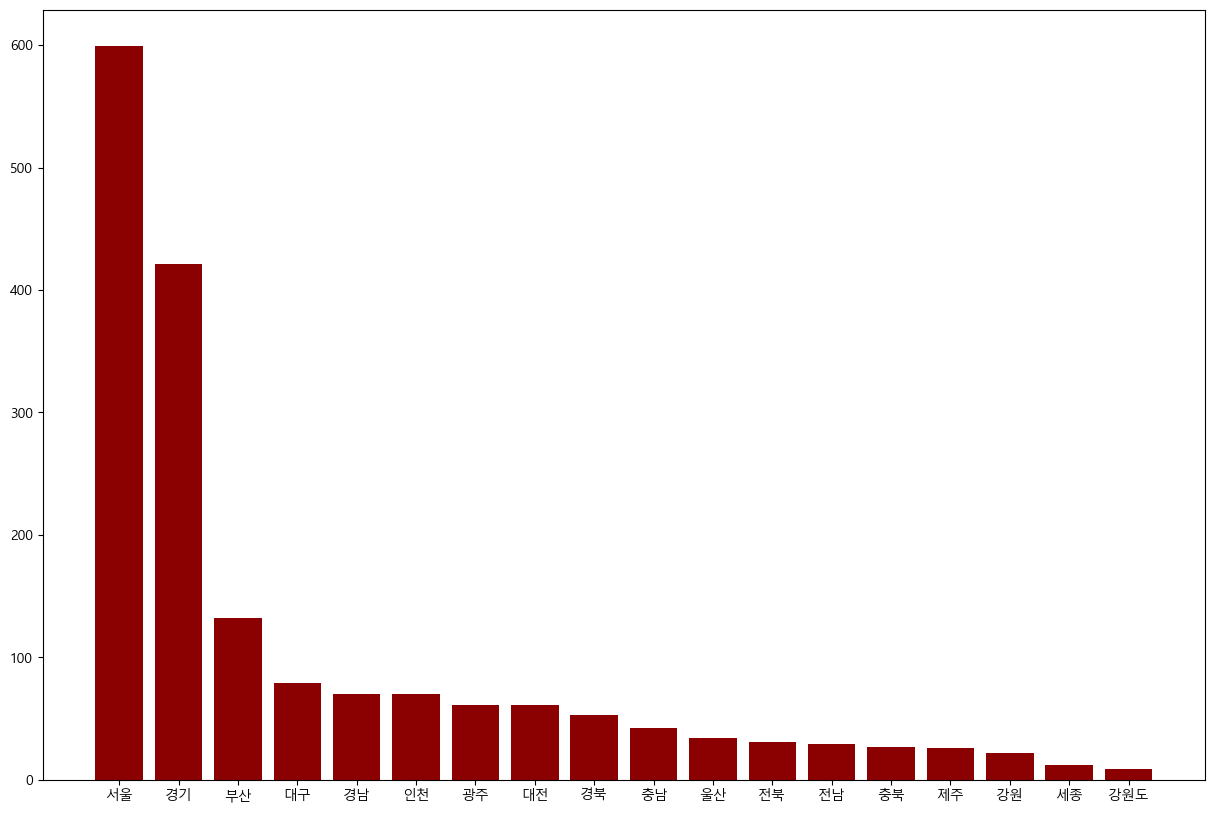

In [17]:
import matplotlib.pyplot as plt

print(df_store.value_counts('시/도'))

plt.figure(figsize=(15, 10))
plt.rc('font', family='Malgun Gothic')
    
x = df_store.value_counts('시/도').index
y = list(df_store.value_counts('시/도'))
plt.bar(x, y, color='darkred')

## 매장 타입별 매장 개수

매장타입
General                 1313
DriveThrough             395
Reserve                   69
DriveThrough&Reserve       1
dtype: int64


([<matplotlib.patches.Wedge at 0x2019f0574f0>,
 [Text(-0.7491393544577194, 0.8054751564155607, 'General'),
  Text(0.7025949294417244, -0.9728105494508058, 'DriveThrough'),
  Text(1.289783633626302, -0.16265970130838597, 'Reserve'),
  Text(1.4999976585493298, -0.0026503483786694594, 'DriveThrough&Reserve')],
 [Text(-0.4086214660678469, 0.4393500853175785, '73.85%'),
  Text(0.4098470421743392, -0.56747282051297, '22.22%'),
  Text(0.7937130053084935, -0.10009827772823753, '3.88%'),
  Text(0.9999984390328864, -0.0017668989191129726, '0.06%')])

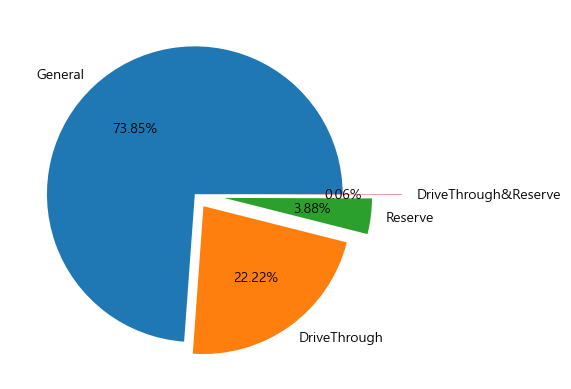

In [18]:
import matplotlib.pyplot as plt

print(df_store.value_counts('매장타입'))

labels = df_store.value_counts('매장타입').index
explode = [0, 0.10, 0.20, 0.40]

plt.pie(df_store.value_counts('매장타입'), labels=labels,autopct='%.2f%%' , explode=explode)